In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import datetime
from itertools import product
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
file = pd.ExcelFile('time series analysis.xlsx')

In [3]:
sales = file.parse(0, parse_dates=True, index_col=0, ddayfirst=True)

In [4]:
sales.rename(columns={'Продажи руб.':'sales_in_rub'}, inplace=True)

In [5]:
sales.index.name = 'month'

In [6]:
sales.head()

,sales_in_rub
month,
2008-01-01,17986229.37
2008-02-01,23571964.82
2008-03-01,25537589.45
2008-04-01,24630951.38
2008-05-01,24429696.26


In [7]:
print(sales.index.tolist()[-12])
print(sales.index.tolist()[-13])
print(sales.index.tolist()[-1])
print(sales.index.tolist()[-12].month)
print(sales.index.tolist()[-13].month)

2013-01-01 00:00:00
2012-12-01 00:00:00
2013-12-01 00:00:00
1
12


In [8]:
train_date = datetime.datetime.strptime("2012-12-01", "%Y-%m-%d")
prediction_date = datetime.datetime.strptime("2013-01-01", "%Y-%m-%d")
prediction_date_end = datetime.datetime.strptime("2013-12-01", "%Y-%m-%d")

In [9]:
sales_train = sales[:train_date]
sales_prediction = sales[prediction_date:]

In [10]:
sales_train.index.tolist()[-1]

Timestamp('2012-12-01 00:00:00')

In [11]:
sales_prediction.index.tolist()[0]

Timestamp('2013-01-01 00:00:00')

In [12]:
sales_train.head()

,sales_in_rub
month,
2008-01-01,17986229.37
2008-02-01,23571964.82
2008-03-01,25537589.45
2008-04-01,24630951.38
2008-05-01,24429696.26


In [13]:
sales_prediction.head()

,sales_in_rub
month,
2013-01-01,NaN
2013-02-01,NaN
2013-03-01,NaN
2013-04-01,NaN
2013-05-01,NaN


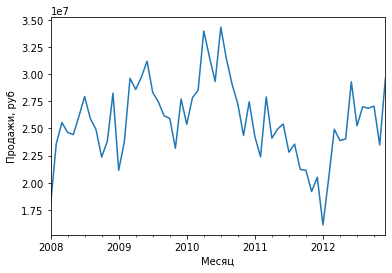

In [14]:
sales_train.sales_in_rub.plot()
plt.ylabel('Продажи, руб')
plt.xlabel('Месяц')
plt.show()

### Первый метод - SARIMAX

Ряд не обладает свойствами стационарности, но тем не менее воспользуемся критерием Дики-Фуллера, а также проведем STL-декомпозицию ряда:

Критерий Дики-Фуллера: p=0.065012


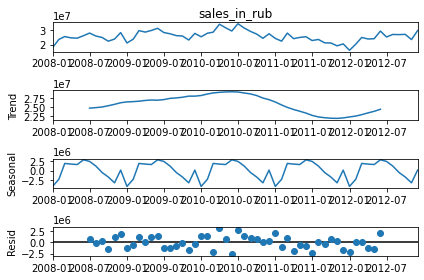

In [15]:
sm.tsa.seasonal_decompose(sales_train.sales_in_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sales_train.sales_in_rub)[1])

Оптимальный параметр преобразования Бокса-Кокса: 1.195532
Критерий Дики-Фуллера: p=0.064430


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


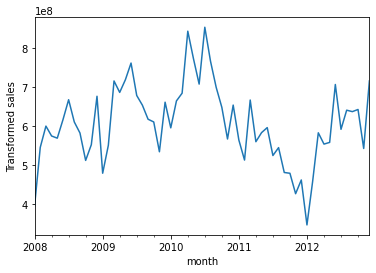

In [16]:
sales_train.loc[:,'sales_box'], lmbda= stats.boxcox(sales_train.sales_in_rub)
sales_train.sales_box.plot()
plt.ylabel(u'Transformed sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sales_train.sales_box)[1])

Сезонность

In [17]:
#sales_train.loc[:,'sales_box_diff'] = sales_train.sales_box - sales_train.sales_box.shift(12)

In [18]:
#sm.tsa.seasonal_decompose(sales_train.sales_box_diff[12:]).plot()
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sales_train.sales_box_diff[12:])[1])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Критерий Дики-Фуллера: p=0.000325


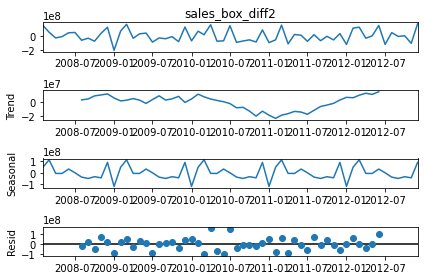

In [19]:
sales_train.loc[:,'sales_box_diff2'] = sales_train['sales_box'] - sales_train['sales_box'].shift(1)
sm.tsa.seasonal_decompose(sales_train.sales_box_diff2[1:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sales_train.sales_box_diff2[1:])[1])

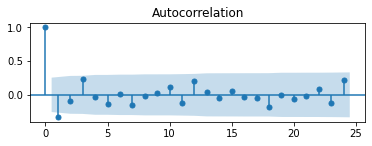

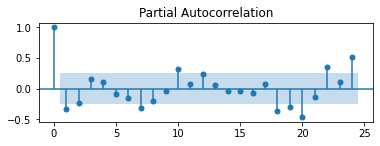

In [20]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sales_train.sales_box_diff2[1:].values.squeeze(), lags=24, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sales_train.sales_box_diff2[1:].values.squeeze(), lags=24, ax=ax)
plt.show()

In [21]:
ps = range(0, 4)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=0
Qs = range(0, 2)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sales_train.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 7.71 s


In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
0   (0, 0, 0, 0)  2325.594456
8   (0, 1, 0, 0)  2326.274575
16  (1, 0, 0, 0)  2326.495057
1   (0, 0, 0, 1)  2327.677669
2   (0, 0, 1, 0)  2327.838895


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              sales_box   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1161.797
Date:                Wed, 16 Jun 2021   AIC                           2325.594
Time:                        03:04:39   BIC                           2327.672
Sample:                    01-01-2008   HQIC                          2326.405
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.311e+15   1.57e+15      4.665      0.000    4.24e+15    1.04e+16
Ljung-Box (L1) (Q):                   6.55   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.01   Pr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.631571
Критерий Дики-Фуллера: p=0.000325


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


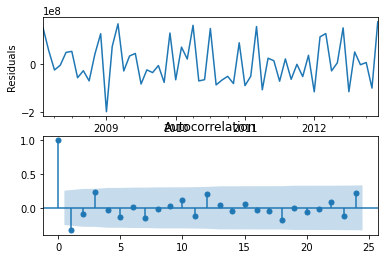

In [26]:
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=24, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


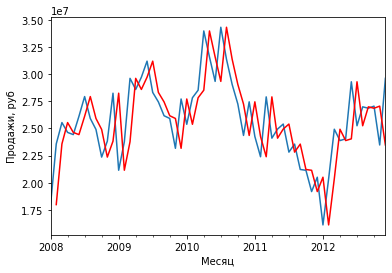

In [27]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

sales_train['model'] = invboxcox(best_model.fittedvalues, lmbda)
sales_train.sales_in_rub.plot()
sales_train.model[1:].plot(color='r')
plt.ylabel('Продажи, руб')
plt.xlabel('Месяц')
plt.show()

### Прогноз

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


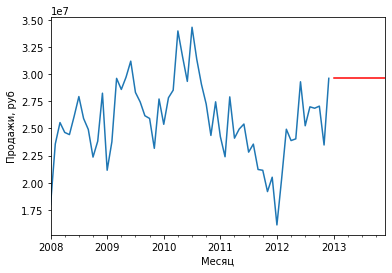

In [28]:
sales2 = sales[:train_date]
sales2 = pd.concat([sales2, sales_prediction])
sales2['forecast'] = invboxcox(best_model.forecast(12), lmbda)
sales2.sales_in_rub.plot()
sales2.forecast.plot(color='r')
plt.ylabel('Продажи, руб')
plt.xlabel('Месяц')
plt.show()